# Section II
Validate your installations, in a notebook by executing:
```
!pip install earthengine-api geemap folium matplotlib pandas geopandas rasterio rasterstats scipy scikit-learn seaborn statsmodels
!earthengine authenticate
```

In [2]:
# Replace by your project numbber:
my_project = 'my-project-000000000000'

In [3]:
# Code Snippet 1.1: Initializing and Testing the GEE Python API
import ee

# Initialize the library
try:
    ee.Initialize(project=my_project)
    print(f"Earth Engine {my_project} initialized successfully!")
    
    # Test with a simple operation
    image = ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20200926')
    print(f"Test image has {image.bandNames().size().getInfo()} bands")
    
except Exception as e:
    print(f"Initialization failed: {e}")

Earth Engine my-project-1505809889235 initialized successfully!
Test image has 19 bands


In [48]:
           
def extract_comprehensive_time_series(collection, region, scale=30, CLOUD_COVER_MAX_PER=20, MIN_PIXELS_RATIO=0.8):
    """
    Extracts comprehensive time-series with multiple metrics and quality indicators.
    
    Returns:
    - ee.FeatureCollection with date, values, and quality metrics
    """
    
    def extract_metrics(image):
        # Calculate multiple reduction metrics
        reduction = image.reduceRegion(
            reducer=ee.Reducer.mean()
                .combine(ee.Reducer.stdDev(), sharedInputs=True)
                .combine(ee.Reducer.count(), sharedInputs=True),
            geometry=region,
            scale=scale,
            maxPixels=1e9
        )
        
        # Extract quality information
        # pixel_count = reduction.get('NDVI_count')
        pixel_count = ee.Number(reduction.get('NDVI_count'))
        cloud_score = image.get('CLOUD_COVER') or -1
        
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'timestamp': image.get('system:time_start'),
            'ndvi_mean': reduction.get('NDVI_mean'),
            'ndvi_stddev': reduction.get('NDVI_stdDev'),
            'pixel_count': pixel_count,
            'cloud_cover': cloud_score,
            # Quality flag: high quality if >80% pixels valid and <20% cloud cover
            'quality_flag': ee.Algorithms.If(
                pixel_count.gt(region.area().multiply(MIN_PIXELS_RATIO).divide(scale * scale))
                    .And(ee.Number(cloud_score).lt(CLOUD_COVER_MAX_PER)),
                'high_quality',
                'low_quality'
            )
        })
    
    return collection.map(extract_metrics)

In [54]:
def analyze_time_series_with_python(gee_features, PERIOD=365):
    """
    Complete workflow for time-series analysis using pandas and scipy.
    """
    import pandas as pd
    import numpy as np
    from scipy import signal
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Convert GEE FeatureCollection to pandas DataFrame
    data = []
    for feature in gee_features['features']:
        props = feature['properties']
        if props.get('ndvi_mean') is not None:
            data.append({
                'date': pd.to_datetime(props['date']),
                'ndvi': props['ndvi_mean'],
                'ndvi_std': props.get('ndvi_stddev', 0),
                'quality': props.get('quality_flag', 'unknown'),
                'cloud_cover': props.get('cloud_cover', -1),
                'pixel_count': props.get('pixel_count', -1),
            })
    
    df = pd.DataFrame(data).set_index('date').sort_index()
    
    # Advanced time-series processing
    # 1. Quality filtering
    high_quality_data = df[df['quality'] == 'high_quality'].copy()
    
    # 2. Temporal smoothing using Savitzky-Golay filter
    if len(high_quality_data) > 10:  # Minimum data points for smoothing
        high_quality_data['ndvi_smoothed'] = signal.savgol_filter(
            high_quality_data['ndvi'], 
            window_length=min(11, len(high_quality_data)//2*2+1), 
            polyorder=3
        )
    
    # 3. Anomaly detection using rolling statistics
    high_quality_data['rolling_mean'] = high_quality_data['ndvi'].rolling(30, center=True).mean()
    high_quality_data['rolling_std'] = high_quality_data['ndvi'].rolling(30, center=True).std()
    high_quality_data['z_score'] = (
        (high_quality_data['ndvi'] - high_quality_data['rolling_mean']) / 
        high_quality_data['rolling_std']
    )
    high_quality_data['anomaly'] = np.abs(high_quality_data['z_score']) > 2.5
    
    # 4. Seasonal decomposition
    if len(high_quality_data) >= PERIOD:  # At least one year of data
        from statsmodels.tsa.seasonal import seasonal_decompose
        decomposition = seasonal_decompose(
            high_quality_data['ndvi'].resample('D').interpolate(),
            model='additive',
            period=365
        )
        
        # Create comprehensive visualization
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        # Original time series with quality indicators
        axes[0].plot(high_quality_data.index, high_quality_data['ndvi'], 'b-', alpha=0.7, label='Original')
        if 'ndvi_smoothed' in high_quality_data.columns:
            axes[0].plot(high_quality_data.index, high_quality_data['ndvi_smoothed'], 'r-', label='Smoothed')
        anomalies = high_quality_data[high_quality_data['anomaly']]
        axes[0].scatter(anomalies.index, anomalies['ndvi'], color='red', s=50, alpha=0.7, label='Anomalies')
        axes[0].set_title('NDVI Time Series with Anomaly Detection')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Trend component
        axes[1].plot(decomposition.trend.index, decomposition.trend.values, 'g-', linewidth=2)
        axes[1].set_title('Long-term Trend')
        axes[1].grid(True, alpha=0.3)
        
        # Seasonal component
        axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, 'orange', linewidth=1)
        axes[2].set_title('Seasonal Pattern')
        axes[2].grid(True, alpha=0.3)
        
        # Residual component
        axes[3].plot(decomposition.resid.index, decomposition.resid.values, 'purple', alpha=0.7)
        axes[3].set_title('Residual Component')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return high_quality_data, decomposition
    
    return high_quality_data, len(high_quality_data)

Found 224 images meeting criteria


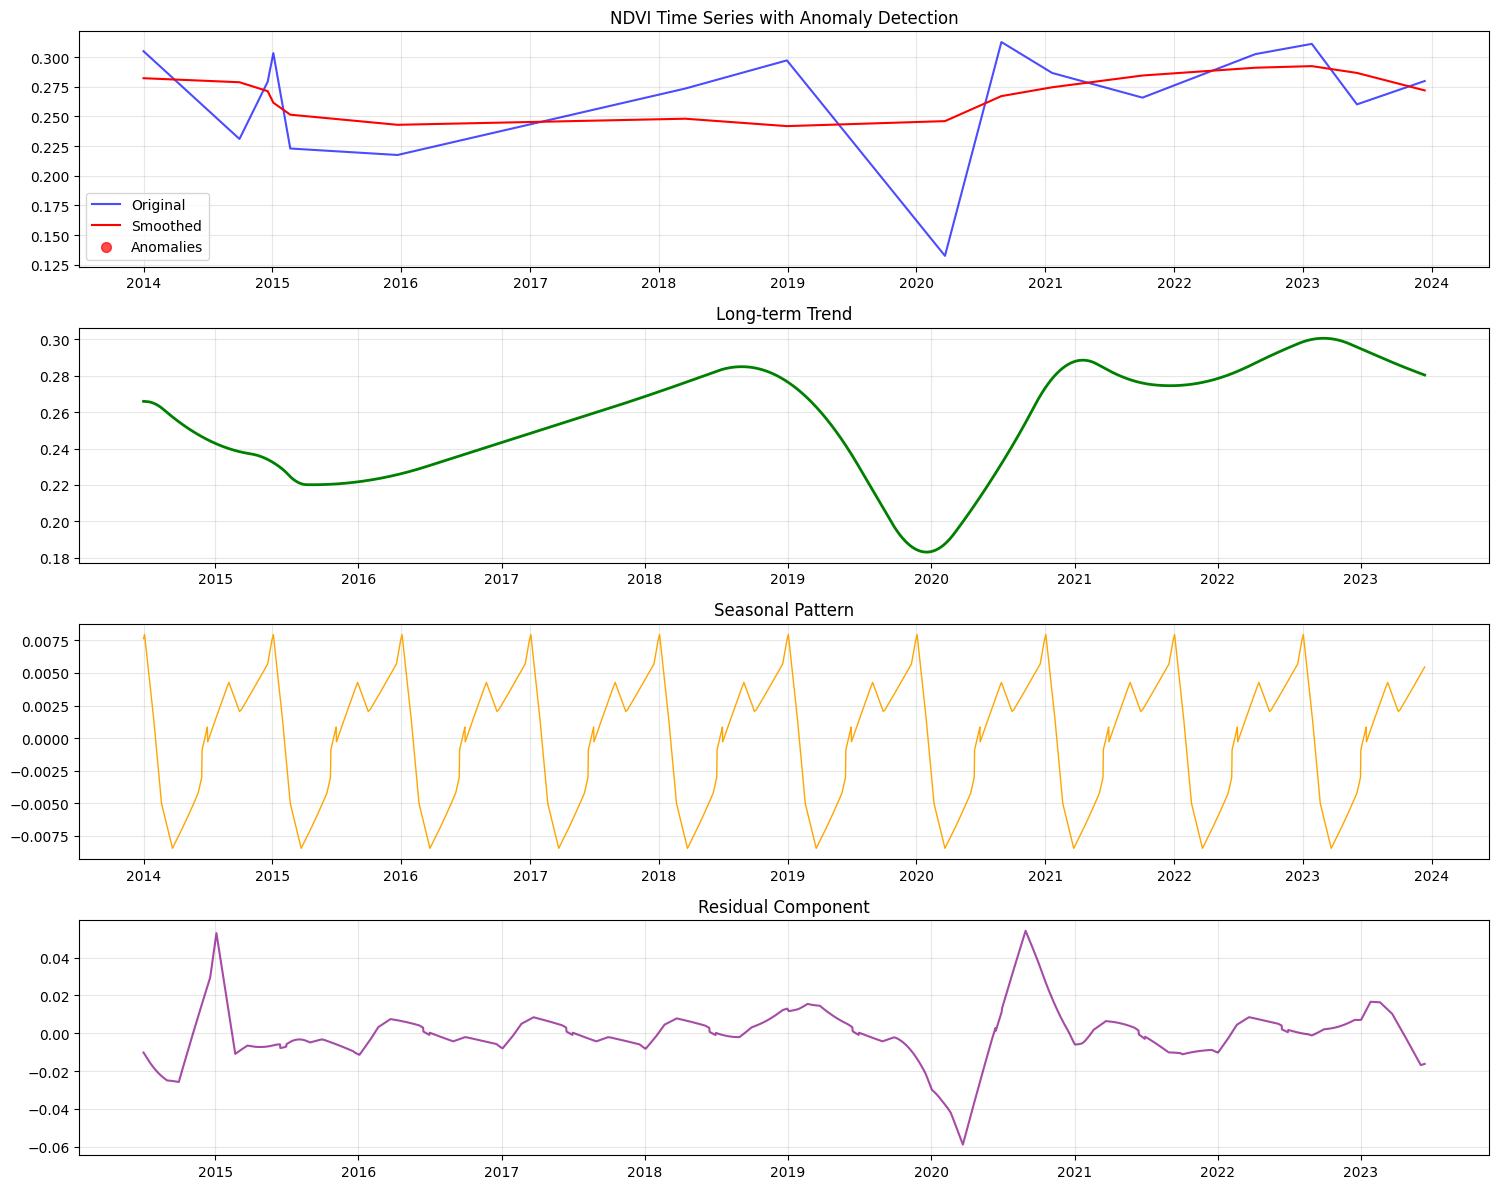

high_quality_data.shape (16, 10)


In [55]:
import ee
import pandas as pd

ee.Initialize(project=my_project)

# Define a function to calculate and add an NDVI band.
def add_ndvi(image):
    # Calculate NDVI using the server-side normalizedDifference() function.
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    # Add the NDVI band to the image.
    return image.addBands(ndvi)

# Define AOI and Image Collection
AOI = ee.Geometry.Rectangle([-74.05, 4.5, -73.95, 4.15])
image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2010-01-01', '2023-12-31') \
    .filterBounds(AOI) \
    .map(add_ndvi)

print(f"Found {image_collection.size().getInfo()} images meeting criteria")

# Use your GEE function to extract time series features
time_series_ee = extract_comprehensive_time_series(image_collection, AOI, scale=30, CLOUD_COVER_MAX_PER=30)

# Get as GeoJSON dictionary (client-side data)
time_series_geojson = time_series_ee.getInfo()

# Use the Python function to analyze
# Landsat 8 has a revisit cycle of about 16 days, so within a year, you typically get roughly 20-23 clear observations per pixel, not a full 365 daily data points.
high_quality_data, decomposition = analyze_time_series_with_python(time_series_geojson, PERIOD=16)

# Now you have a pandas DataFrame for further analysis and the seasonal decomposition object
print("Records of quality in the dataframe:", high_quality_data.shape[0])

In [56]:
# Now you have a pandas DataFrame for further analysis and the seasonal decomposition object
high_quality_data.head(5)

,ndvi,ndvi_std,quality,cloud_cover,pixel_count,ndvi_smoothed,rolling_mean,rolling_std,z_score,anomaly
date,,,,,,,,,,
2014-01-01,0.305019,0.088778,high_quality,21.38,478641,0.282272,NaN,NaN,NaN,False
2014-09-30,0.231047,0.128654,high_quality,27.02,478641,0.278880,NaN,NaN,NaN,False
2014-12-19,0.279338,0.113438,high_quality,29.90,478640,0.271363,NaN,NaN,NaN,False
2015-01-04,0.303460,0.090708,high_quality,5.13,478641,0.261614,NaN,NaN,NaN,False
2015-02-21,0.223006,0.113275,high_quality,25.33,478641,0.251526,NaN,NaN,NaN,False


In [66]:
def advanced_cloud_mask(image, new_scale=30):
    """
    Multi-criteria cloud & shadow mask for Landsat 8/9.
    Uses QA flags plus spectral tests, and checks if ST_B10 exists.
    """
    qa_pixel = image.select('QA_PIXEL')
    qa_radsat = image.select('QA_RADSAT')

    # Basic QA masks
    cloud_mask  = qa_pixel.bitwiseAnd(1 << 3).eq(0)
    shadow_mask = qa_pixel.bitwiseAnd(1 << 4).eq(0)
    snow_mask   = qa_pixel.bitwiseAnd(1 << 5).eq(0)

    # Spectral tests
    blue  = image.select('SR_B2').multiply(0.0000275).add(-0.2)
    green = image.select('SR_B3').multiply(0.0000275).add(-0.2)
    red   = image.select('SR_B4').multiply(0.0000275).add(-0.2)
    nir   = image.select('SR_B5').multiply(0.0000275).add(-0.2)
    swir1 = image.select('SR_B6').multiply(0.0000275).add(-0.2)

    white_test = blue.gt(0.2).And(green.gt(0.2)).And(red.gt(0.2))
    hot_test   = swir1.divide(nir).gt(1.5)

    # Cold pixel test – server-side band check
    has_st = image.bandNames().contains('ST_B10')
    temp = ee.Image(
        ee.Algorithms.If(
            has_st,
            image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15),
            ee.Image(0)  # fallback if band missing
        )
    )
    cold_test = temp.lt(-10)

    # Combine all masks
    comprehensive_mask = (
        cloud_mask.And(shadow_mask)
                  .And(snow_mask)
                  .And(white_test.Not())
                  .And(hot_test.Not())
                  .And(cold_test.Not())
    )

    saturated_mask = qa_radsat.eq(0)

    final_mask = comprehensive_mask.And(saturated_mask)

    # Add a quality score attribute
    quality_score = final_mask.reduceRegion(
        reducer=ee.Reducer.mean(),
        scale=new_scale,
        maxPixels=1e6
    ).get('QA_PIXEL')

    return image.updateMask(final_mask).set('quality_score', quality_score)

In [79]:
import ee

ee.Initialize(project=my_project)

# Define a function to calculate and add an NDVI band.
def add_ndvi(image):
    # Calculate NDVI using the server-side normalizedDifference() function.
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    # Add the NDVI band to the image.
    return image.addBands(ndvi)

# Define AOI and Image Collection
AOI = ee.Geometry.Rectangle([-74.05, 4.5, -73.95, 4.15])
image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2010-01-01', '2023-12-31') \
    .filterBounds(AOI) \
    .map(lambda image: advanced_cloud_mask(image, new_scale=50)) \
    .map(add_ndvi)

print(f"Found {image_collection.size().getInfo()} images meeting criteria")

first_img = image_collection.first().select('NDVI')

task = ee.batch.Export.image.toDrive(
    image=first_img,
    description='ndvi_advanced_cloud_mask_example',
    folder='GEE_Exports',
    fileFormat='GeoTIFF',
    scale=30,
    region=AOI
)
task.start()


Found 224 images meeting criteria


In [85]:
def calculate_comprehensive_indices(image):
    """
    Calculates a comprehensive suite of spectral indices for multi-faceted analysis.
    """
    # Normalized bands for easier calculation
    blue = image.select('SR_B2').multiply(0.0000275).add(-0.2)
    green = image.select('SR_B3').multiply(0.0000275).add(-0.2)
    red = image.select('SR_B4').multiply(0.0000275).add(-0.2)
    nir = image.select('SR_B5').multiply(0.0000275).add(-0.2)
    swir1 = image.select('SR_B6').multiply(0.0000275).add(-0.2)
    swir2 = image.select('SR_B7').multiply(0.0000275).add(-0.2)
    
    # Vegetation indices
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    
    evi = nir.subtract(red).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
    ).multiply(2.5).rename('EVI')
    
    savi = nir.subtract(red).divide(nir.add(red).add(0.5)).multiply(1.5).rename('SAVI')
    
    # Moisture indices
    ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')
    msi = swir1.divide(nir).rename('MSI')
    
    # Water indices
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')
    mndwi = green.subtract(swir1).divide(green.add(swir1)).rename('MNDWI')
    
    # Soil indices
    nbr = nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')
    ndbi = swir1.subtract(nir).divide(swir1.add(nir)).rename('NDBI')
    
    return image.addBands([ndvi, evi, savi, ndmi, msi, ndwi, mndwi, nbr, ndbi])
    

def create_classification_features(image_collection, region, start_date, end_date, new_scale):
    """
    Creates comprehensive feature set for land cover classification.
    Combines spectral, temporal, and topographic variables.
    """
    
    # 1. Spectral features: Annual median composite
    spectral_composite = image_collection \
        .filterBounds(region) \
        .filterDate(start_date, end_date) \
        .map(lambda image: advanced_cloud_mask(image, new_scale=new_scale)) \
        .map(calculate_comprehensive_indices) \
        .median()
    
    # 2. Temporal features: Phenology metrics
    def calculate_phenology_metrics(collection, region):
        # Monthly composites for phenology analysis
        months = ee.List.sequence(1, 12)

        # Define a function to calculate and add an NDVI band.
        def add_ndvi(image):
            # Calculate NDVI using the server-side normalizedDifference() function.
            ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
            # Add the NDVI band to the image.
            return image.addBands(ndvi)
        
        def monthly_composite(month):
            return ndvi_collection \
                .filter(ee.Filter.calendarRange(month, month, 'month')) \
                .median() \
                .set('month', month)
                #.filter(ee.Filter.eq('month', month)) \
        
        ndvi_collection = collection.map(add_ndvi)
        monthly_collection = ee.ImageCollection.fromImages(months.map(monthly_composite))
        # Example of debugging line, getInfo method will retrieve data from the server:
        print(monthly_collection.first().bandNames().getInfo())
        
        # Calculate phenology metrics
        ndvi_max = monthly_collection.select('NDVI').max().rename('NDVI_max')
        ndvi_min = monthly_collection.select('NDVI').min().rename('NDVI_min')
        ndvi_range = ndvi_max.subtract(ndvi_min).rename('NDVI_range')
        ndvi_stddev = monthly_collection.select('NDVI').reduce(ee.Reducer.stdDev()).rename('NDVI_temporal_std')
        
        # Growing season metrics
        # growing_season = monthly_collection.filter(ee.Filter.calendarRange(4, 9, 'month'))
        growing_season = monthly_collection.filter(ee.Filter.rangeContains('month', 4, 9))
        growing_season_mean = growing_season.select('NDVI').mean().rename('NDVI_growing_season')
        
        return ee.Image.cat([ndvi_max, ndvi_min, ndvi_range, ndvi_stddev, growing_season_mean])
    
    phenology_features = calculate_phenology_metrics(
        image_collection.filterBounds(region).filterDate(start_date, end_date), 
        region
    )
    
    # 3. Topographic features
    dem = ee.Image('USGS/SRTMGL1_003').clip(region)
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    
    # Topographic position index (relative elevation)
    tpi = dem.subtract(dem.focalMean(300, 'circle', 'meters')).rename('tpi')
    
    # 4. Ancillary data
    # Distance to water bodies
    water_mask = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence').gt(50)
    distance_to_water = water_mask.fastDistanceTransform().sqrt().rename('dist_to_water')
    
    # Combine all features
    feature_stack = ee.Image.cat([
        spectral_composite,
        phenology_features,
        slope, aspect, tpi,
        distance_to_water
    ]).clip(region).toDouble()   # 64bit or .toFloat() if Float32 is fine
    
    return feature_stack

In [88]:
# Initialize Earth Engine with Project context
ee.Initialize(project=my_project)

# Define AOI and Image Collection
AOI = ee.Geometry.Rectangle([-74.0, 4.25, -73.9, 4.15])

new_scale = 250
# Load and filter Landsat 8 imagery
feature_stack = create_classification_features(
    image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'), 
    region = AOI, 
    start_date = '2021-01-01', 
    end_date = '2023-12-31',
    new_scale = new_scale
)

# Define the export task.
task = ee.batch.Export.image.toDrive(
    image=feature_stack.clip(AOI),  # Clip the image to our AOI
    description='NDVI_Adv_features',
    folder='GEE_Exports',
    scale=new_scale,  # Spatial resolution in meters (Landsat is 30)
    region=AOI
)
# Start the export task. You can monitor its progress in the GEE Code Editor's 'Tasks' tab.
task.start()

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI']
